In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from polygon import RESTClient


In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'

In [3]:
def get_data_by_hour(symbol):
    key = 'YZj_Ugd4fkCRX57STH5MeItRlAz31DRN'
    client = RESTClient(key)
    query = True
    from_date = "2012-01-01"
    to_date = datetime.today().date().strftime("%Y-%m-%d")
    data_for_df = []
    while query:
        resp = client.stocks_equities_aggregates(symbol, 1, "hour", from_date, to_date, unadjusted=True, limit=50000)
        if 'results' in dir(resp):
            results = resp.results
            data_for_df = data_for_df + results[:-1]
            date = datetime.fromtimestamp((resp.results[-1]['t'])/1000.0)
            from_date = date.date().strftime("%Y-%m-%d")
            if from_date == to_date:
                query = False 
        else:
            query = False 

    
    handledData = pd.DataFrame(data=data_for_df)
    handledData.columns = ['volume', 'vw', 'open', 'close', 'high', 'low', 'time', 'number']
    handledData.drop_duplicates(subset=['time'], inplace=True)
    handledData.index = pd.to_datetime(handledData['time'].values, unit='ms').to_pydatetime()
    handledData.drop('time', axis=1, inplace=True)
    handledData.dropna(inplace=True)

    plt.figure(figsize=(15, 5))
    plt.plot(handledData.index, handledData['close'])
    plt.grid(True)
    return handledData

,volume,vw,open,close,high,low,number
2012-01-03 12:00:00,1100.0,5.5000,5.50,5.50,5.500,5.50,6
2012-01-03 13:00:00,24951.0,5.5243,5.48,5.54,5.540,5.48,29
2012-01-03 14:00:00,1359139.0,5.5509,5.40,5.55,5.590,5.40,3115
2012-01-03 15:00:00,2822896.0,5.5226,5.55,5.52,5.580,5.45,5652
2012-01-03 16:00:00,1179854.0,5.4913,5.52,5.49,5.525,5.47,2604
...,...,...,...,...,...,...,...
2021-05-18 20:00:00,357285.0,74.4412,74.44,74.35,74.620,74.35,882
2021-05-18 21:00:00,15594.0,74.3818,74.35,74.40,74.440,74.34,233
2021-05-18 22:00:00,11342.0,74.3936,74.40,74.38,74.440,74.31,115
2021-05-18 23:00:00,41856.0,74.3526,74.36,74.10,74.500,74.10,335


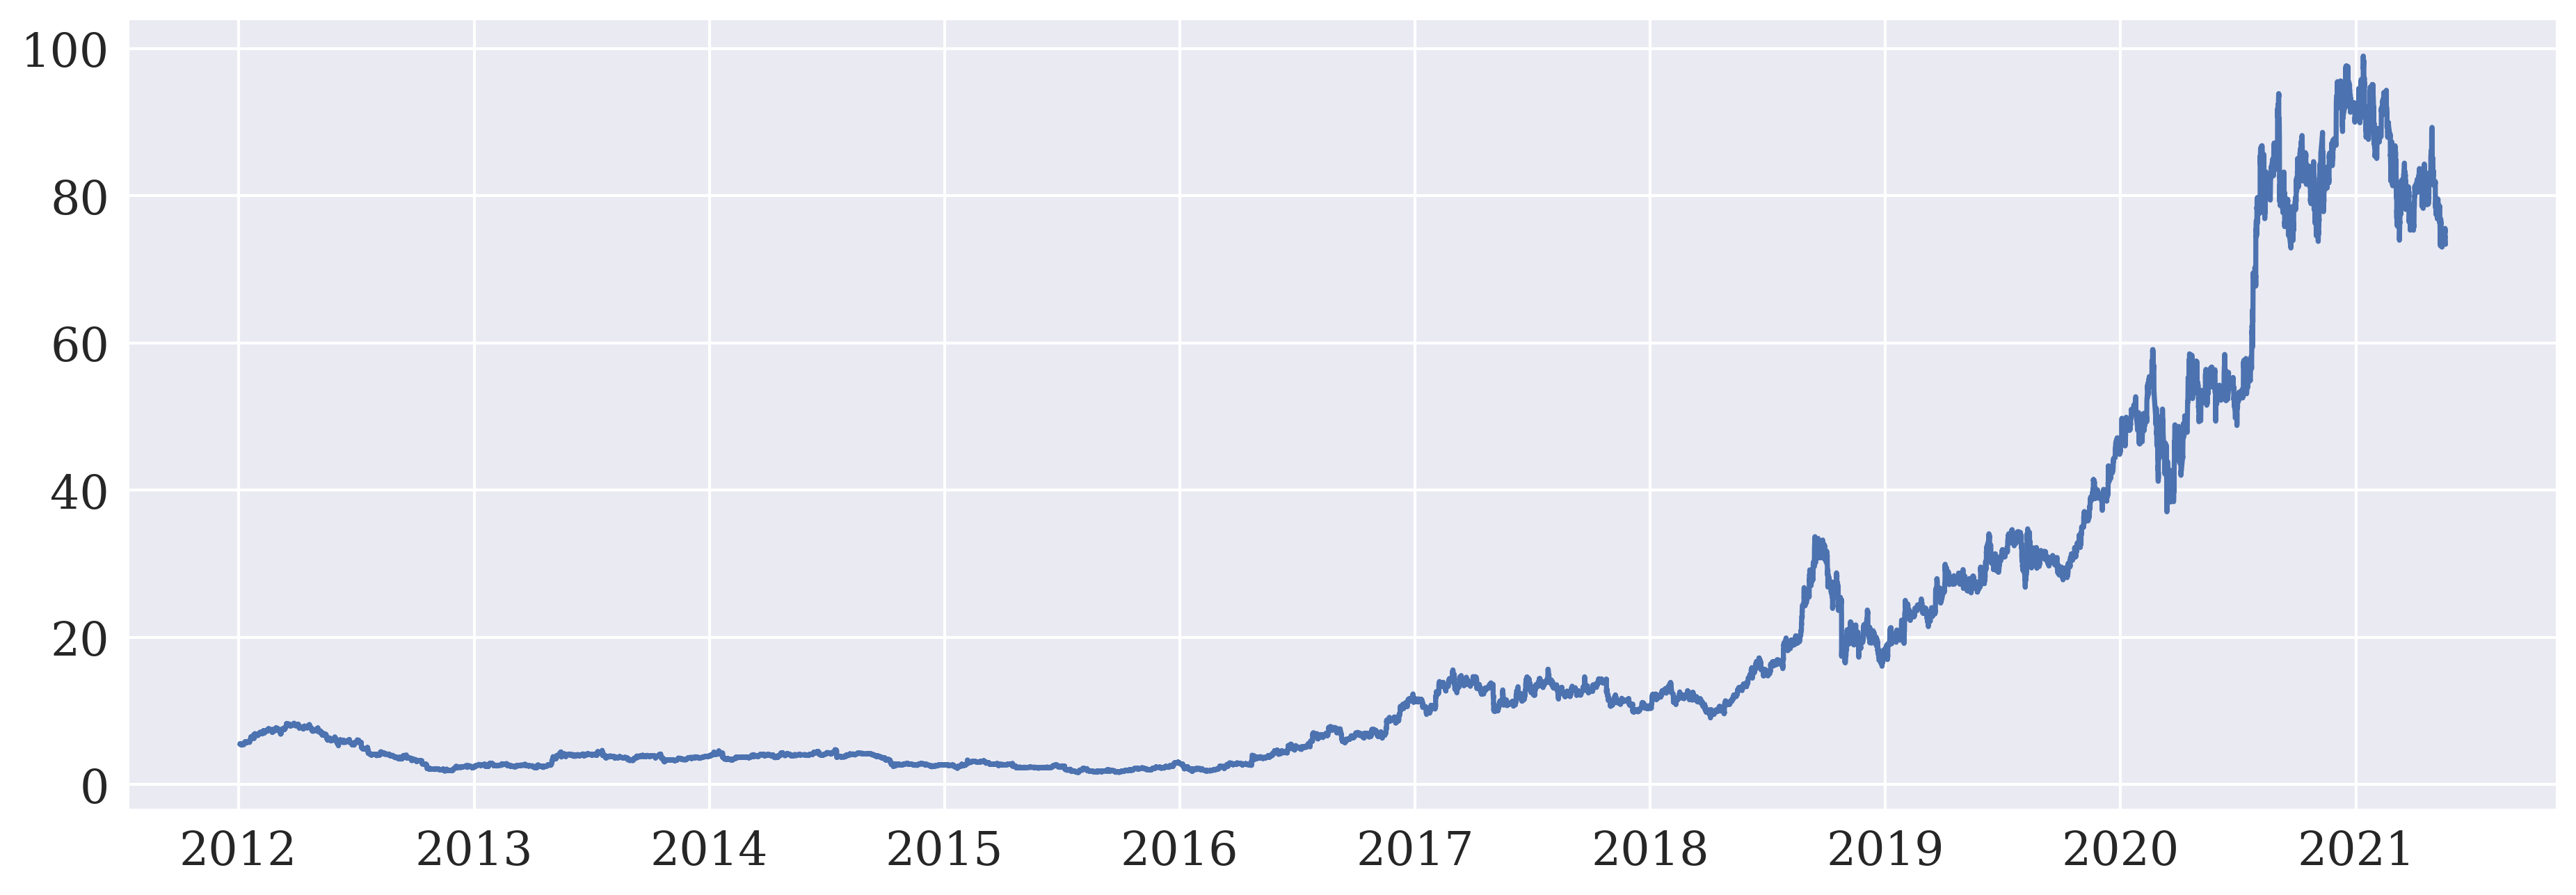

In [4]:
data_stock = get_data_by_hour("AMD")
data_stock

In [5]:
data_stock.loc['2012-06-21 10:00:00']

volume    100.00
vw          6.12
open        6.12
close       6.12
high        6.12
low         6.12
number      1.00
Name: 2012-06-21 10:00:00, dtype: float64

In [6]:
price = data_stock['close']


def get_Daily_Volatility(close,span0=24):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0
df0 = get_Daily_Volatility(price)

#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10 
#the up and low boundary multipliers
upper_lower_multipliers = [3, 2]
#allign the index
prices = price[daily_volatility.index]

def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 'price', 'vert_barrier', 'top_barrier', 'bottom_barrier'], index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc[daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price', \
        'vert_barrier','top_barrier', 'bottom_barrier']] = \
         days_passed, prices.loc[day], vert_barrier, \
         top_barrier, bottom_barrier
    barriers['out'] = None
    return barriers


barriers = get_3_barriers()

def get_labels():
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
                # assign the initial and final price
                price_initial = barriers.price[start]
                price_final = barriers.price[end]
    # assign the top and bottom barriers
                top_barrier = barriers.top_barrier[i]
                bottom_barrier = barriers.bottom_barrier[i]
    #set the profit taking and stop loss conditons
                condition_pt = (barriers.price[start: end] >= \
                 top_barrier).any()
                condition_sl = (barriers.price[start: end] <= \
                 bottom_barrier).any()
    #assign the labels
                if condition_pt: 
                    barriers['out'][i] = 1
                elif condition_sl: 
                    barriers['out'][i] = -1    
                else: 
                    barriers['out'][i] = 0
    return

get_labels()

In [7]:
barriers.out.value_counts()

 0    13484
-1    11267
 1     8295
Name: out, dtype: int64

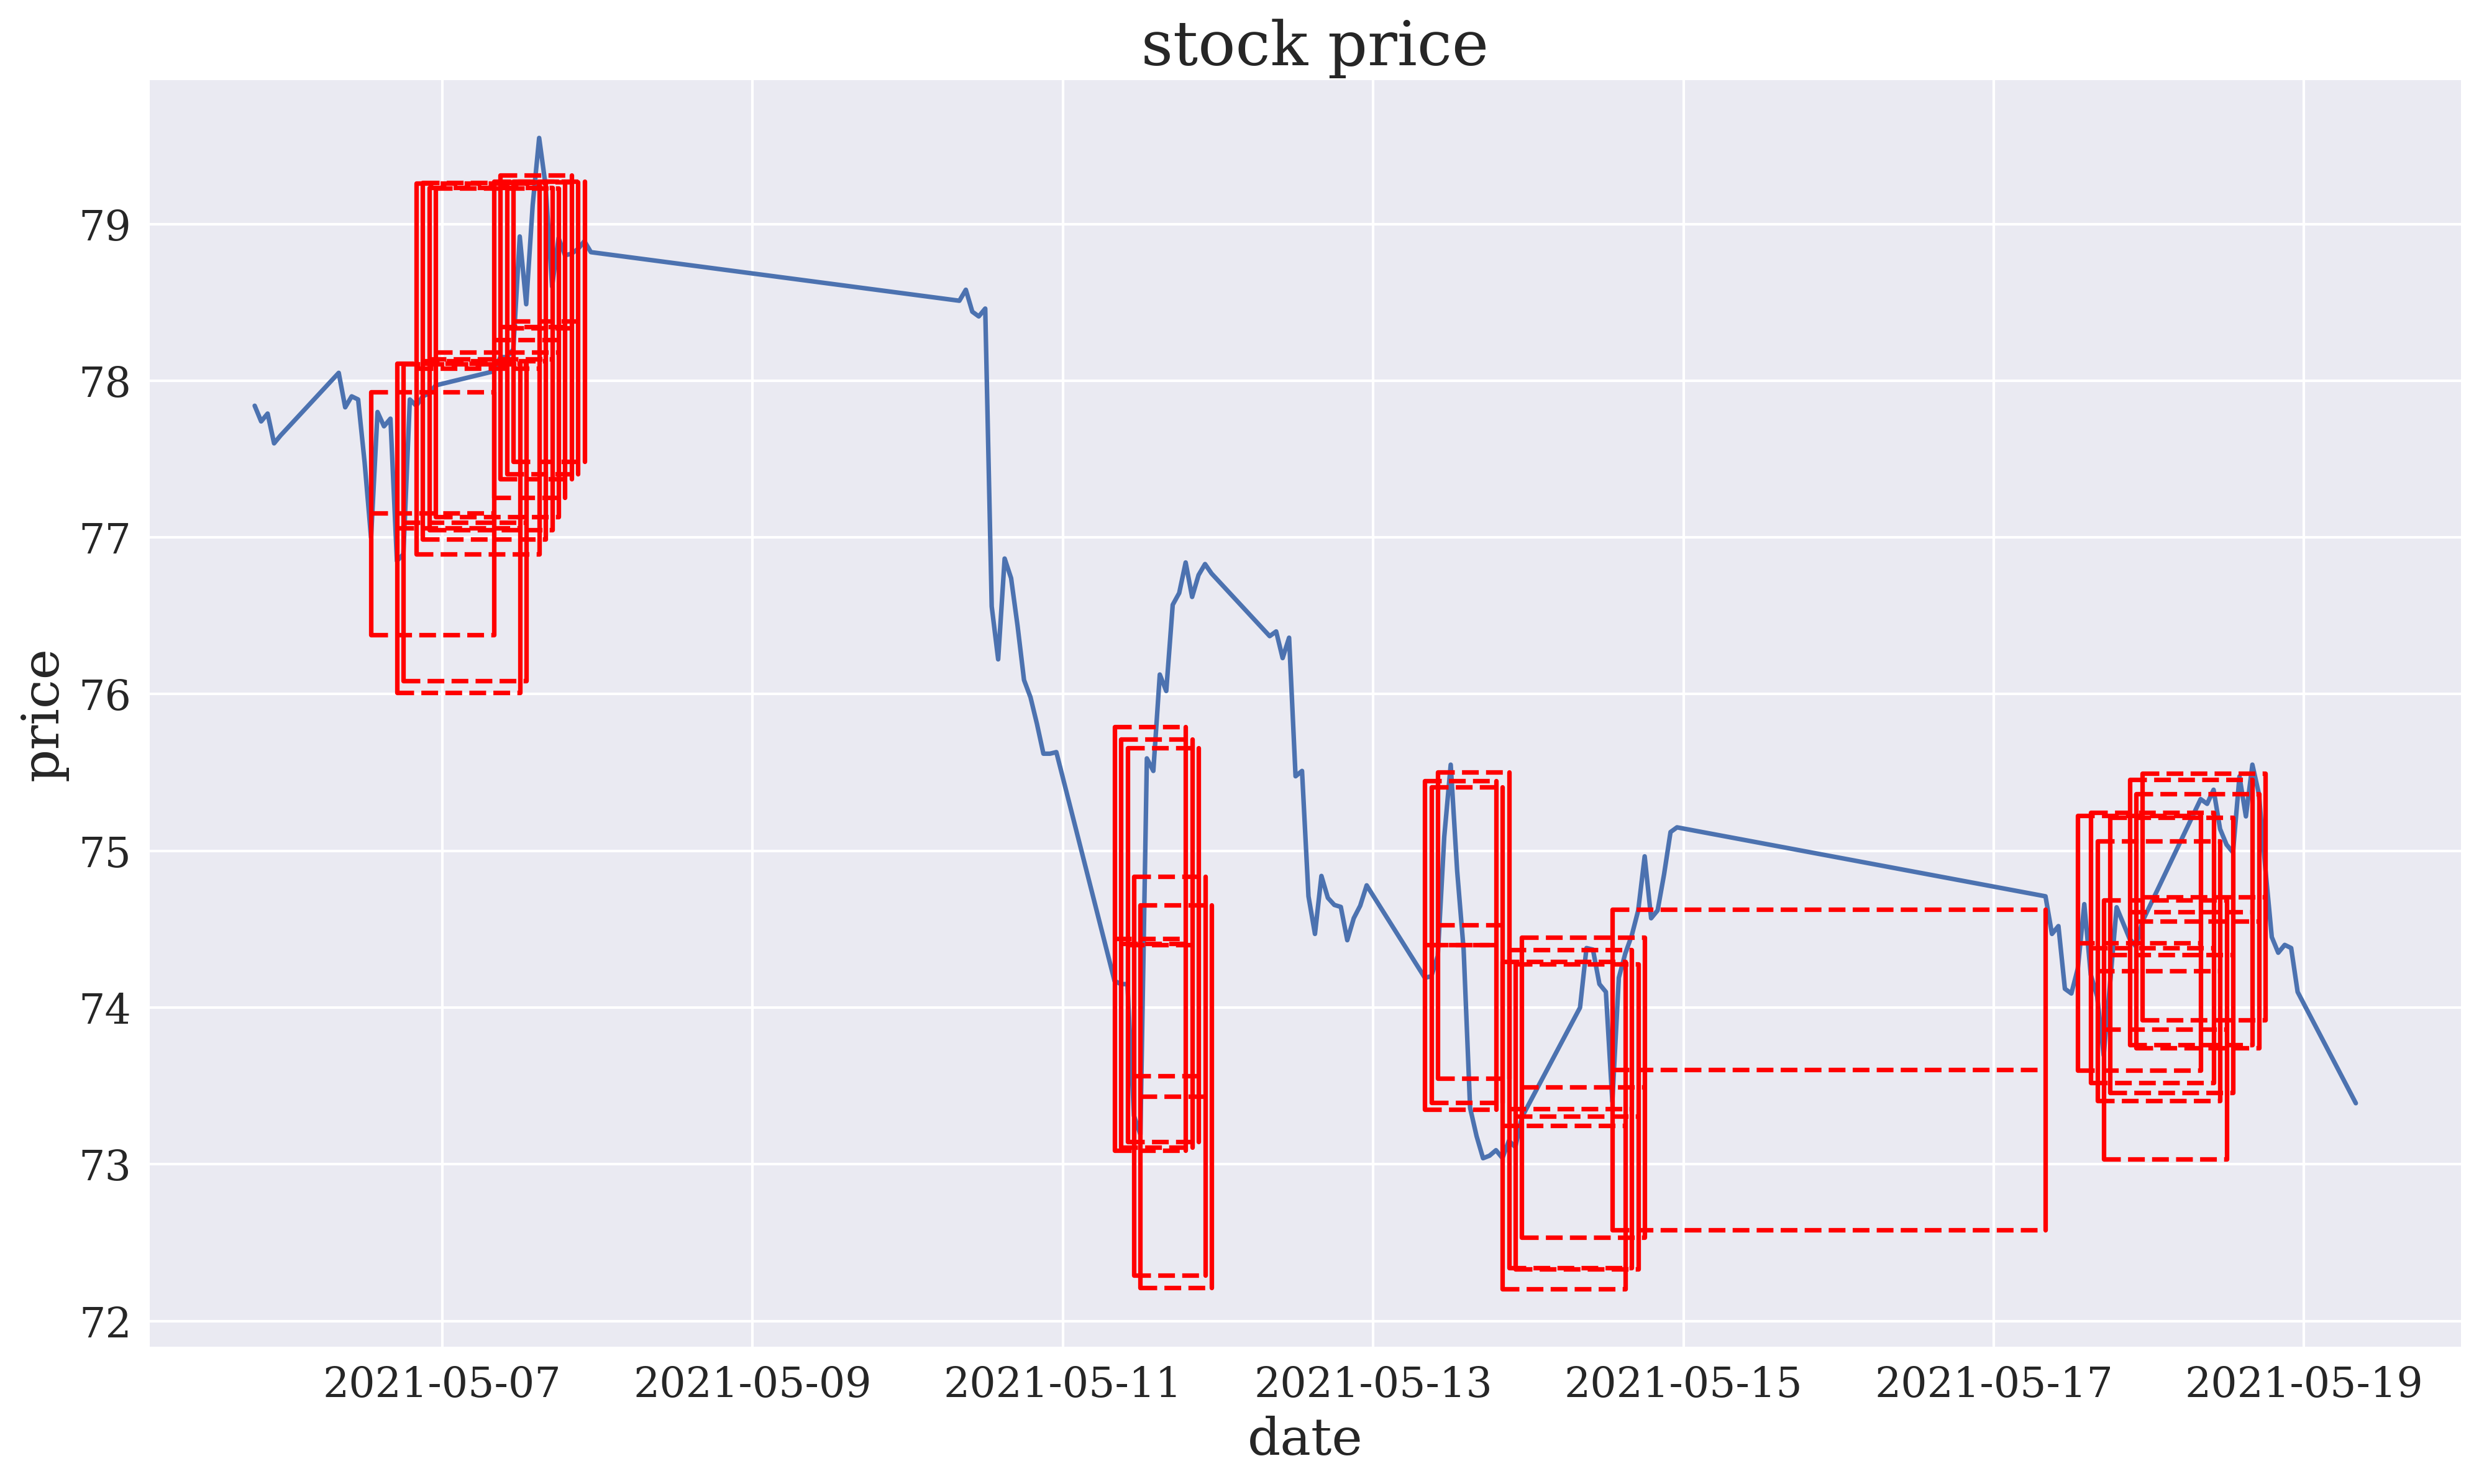

In [8]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-150:])
for i in barriers.index[-155:]:
    barrier = barriers.loc[i]
    start = i
    end = barrier.vert_barrier
    if not pd.isnull(end) and barrier.out == 1:
        upper_barrier = barrier.top_barrier
        lower_barrier = barrier.bottom_barrier
        ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
        ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
        ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
        ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
        ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

In [9]:
def create_HLCV(i): 
    df = pd.DataFrame(index=data_stock.index)
    df[f'high_{i}'] = data_stock.high.rolling(i).max()
    df[f'low_{i}'] = data_stock.low.rolling(i).min()
    df[f'close_{i}'] = data_stock.close.rolling(i).\
                        apply(lambda x:x[-1]) 
    df[f'volume_{i}'] = data_stock.volume.rolling(i).sum()
    
    return df

In [10]:
def create_features(i):
    df = create_HLCV(i)
    high = df[f'high_{i}']
    low = df[f'low_{i}']
    close = df[f'close_{i}']
    volume = df[f'volume_{i}']
    features = pd.DataFrame(index=data_stock.index)
    features[f'volume_{i}'] = volume
    features[f'price_spread_{i}'] = high - low
    features[f'close_loc_{i}'] = (high - close) / (high - low)
    features[f'close_change_{i}'] = close.diff()
    
    return features

In [11]:
def create_bunch_of_features():
    days = [1,2,3,5,6,7,8,9,10,20,40,60]
    bunch_of_features = pd.DataFrame(index=data_stock.index)
    for day in days:
        f = create_features(day)
        bunch_of_features = bunch_of_features.join(f)
    
    return bunch_of_features

bunch_of_features = create_bunch_of_features()
bunch_of_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33059 entries, 2012-01-03 12:00:00 to 2021-05-19 08:00:00
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   volume_1         33059 non-null  float64
 1   price_spread_1   33059 non-null  float64
 2   close_loc_1      31030 non-null  float64
 3   close_change_1   33058 non-null  float64
 4   volume_2         33058 non-null  float64
 5   price_spread_2   33058 non-null  float64
 6   close_loc_2      32809 non-null  float64
 7   close_change_2   33057 non-null  float64
 8   volume_3         33057 non-null  float64
 9   price_spread_3   33057 non-null  float64
 10  close_loc_3      33023 non-null  float64
 11  close_change_3   33056 non-null  float64
 12  volume_5         33055 non-null  float64
 13  price_spread_5   33055 non-null  float64
 14  close_loc_5      33055 non-null  float64
 15  close_change_5   33054 non-null  float64
 16  volume_6         33054 

In [12]:
dropna_barriers = barriers.dropna()
data = bunch_of_features[60:-13].assign(out=dropna_barriers[58:-2].out)
data.dropna(inplace=True)
out = data.out
out=out.astype('int')
data.drop('out', axis=1, inplace=True)
data

,volume_1,price_spread_1,close_loc_1,close_change_1,volume_2,price_spread_2,close_loc_2,close_change_2,volume_3,price_spread_3,...,close_loc_20,close_change_20,volume_40,price_spread_40,close_loc_40,close_change_40,volume_60,price_spread_60,close_loc_60,close_change_60
2012-01-10 13:00:00,15004.0,0.04,0.250000,0.0200,15304.0,0.04,0.250000,0.0200,16742.0,0.11,...,0.033333,0.0200,35540898.0,0.33,0.030303,0.0200,55633821.0,0.330,0.030303,0.0200
2012-01-10 14:00:00,1393823.0,0.10,0.450000,0.0250,1408827.0,0.10,0.450000,0.0250,1409127.0,0.10,...,0.125000,0.0250,36908307.0,0.39,0.115385,0.0250,57002693.0,0.390,0.115385,0.0250
2012-01-10 15:00:00,1349910.0,0.05,0.800000,-0.0050,2743733.0,0.10,0.500000,-0.0050,2758737.0,0.10,...,0.138889,-0.0050,38253617.0,0.39,0.128205,-0.0050,56993464.0,0.390,0.128205,-0.0050
2012-01-10 16:00:00,2673112.0,0.08,0.093750,0.0225,4023022.0,0.09,0.194444,0.0225,5416845.0,0.10,...,0.076389,0.0225,40925629.0,0.39,0.070513,0.0225,56843680.0,0.390,0.070513,0.0225
2012-01-10 17:00:00,1272293.0,0.04,0.000000,0.0275,3945405.0,0.10,0.000000,0.0275,5295315.0,0.10,...,0.000000,0.0275,42179422.0,0.39,0.000000,0.0275,56936119.0,0.390,0.000000,0.0275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-17 23:00:00,39354.0,0.28,0.142857,0.1600,53037.0,0.28,0.142857,0.1600,110289.0,0.28,...,0.459716,0.1600,103155359.0,3.02,0.321192,0.1600,165534133.0,4.615,0.555796,0.1600
2021-05-18 08:00:00,6581.0,0.30,0.500000,0.7800,45935.0,1.17,0.128205,0.7800,59618.0,1.17,...,0.090047,0.7800,99096674.0,3.02,0.062914,0.7800,165190932.0,3.630,0.220386,0.7800
2021-05-18 09:00:00,6274.0,0.16,0.937500,-0.0300,12855.0,0.30,0.600000,-0.0300,52209.0,1.17,...,0.104265,-0.0300,92334810.0,2.80,0.078571,-0.0300,158560807.0,3.500,0.200000,-0.0300
2021-05-18 10:00:00,7196.0,0.13,0.307692,0.0900,13470.0,0.16,0.375000,0.0900,20051.0,0.30,...,0.061611,0.0900,86546466.0,2.80,0.046429,0.0900,150988578.0,3.500,0.174286,0.0900


In [13]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=20)

model.fit(data, out)

Learning rate set to 0.5
0:	learn: 1.0654204	total: 84.9ms	remaining: 1.61s
1:	learn: 1.0536830	total: 104ms	remaining: 934ms
2:	learn: 1.0471625	total: 124ms	remaining: 705ms
3:	learn: 1.0413939	total: 144ms	remaining: 577ms
4:	learn: 1.0381531	total: 163ms	remaining: 488ms
5:	learn: 1.0352009	total: 182ms	remaining: 425ms
6:	learn: 1.0323793	total: 202ms	remaining: 375ms
7:	learn: 1.0302328	total: 227ms	remaining: 341ms
8:	learn: 1.0283708	total: 247ms	remaining: 302ms
9:	learn: 1.0269367	total: 268ms	remaining: 268ms
10:	learn: 1.0244807	total: 290ms	remaining: 238ms
11:	learn: 1.0229211	total: 309ms	remaining: 206ms
12:	learn: 1.0213262	total: 330ms	remaining: 178ms
13:	learn: 1.0185580	total: 351ms	remaining: 151ms
14:	learn: 1.0169797	total: 372ms	remaining: 124ms
15:	learn: 1.0152586	total: 392ms	remaining: 97.9ms
16:	learn: 1.0139012	total: 410ms	remaining: 72.4ms
17:	learn: 1.0095230	total: 432ms	remaining: 48ms
18:	learn: 1.0072851	total: 454ms	remaining: 23.9ms
19:	learn: 1.

In [14]:
predictions = model.predict(bunch_of_features[-30:])

In [15]:
predictions

array([[ 0],
       [ 1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 0],
       [ 1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [-1],
       [ 1],
       [ 1],
       [ 1]])

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion="entropy")
clf.fit(data, out)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=1000)

In [17]:
predictions2 = clf.predict(bunch_of_features.iloc[-30:])

In [18]:
predictions2

array([ 0,  0,  1, -1,  1,  1,  1,  1,  0,  0,  1,  1,  1, -1, -1, -1, -1,
       -1,  0,  1,  0,  0,  0,  0,  0,  0, -1, -1,  0,  1])

In [19]:
barriers[-30:]

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
2021-05-17 11:00:00,33028,74.12,2021-05-17 22:00:00,75.163348,73.424435,0
2021-05-17 12:00:00,33029,74.09,2021-05-17 23:00:00,75.090342,73.423105,0
2021-05-17 13:00:00,33030,74.2497,2021-05-18 08:00:00,75.22377,73.60032,1
2021-05-17 14:00:00,33031,74.66,2021-05-18 09:00:00,75.663641,73.990906,-1
2021-05-17 15:00:00,33032,74.21,2021-05-18 10:00:00,75.243232,73.521178,1
2021-05-17 16:00:00,33033,74.0698,2021-05-18 11:00:00,75.064335,73.406776,1
2021-05-17 17:00:00,33034,73.695,2021-05-18 12:00:00,74.687039,73.03364,1
2021-05-17 18:00:00,33035,74.16,2021-05-18 13:00:00,75.211184,73.45921,1
2021-05-17 19:00:00,33036,74.64,2021-05-18 14:00:00,75.735122,73.909919,0
2021-05-17 20:00:00,33037,74.54,2021-05-18 15:00:00,75.594326,73.837116,0


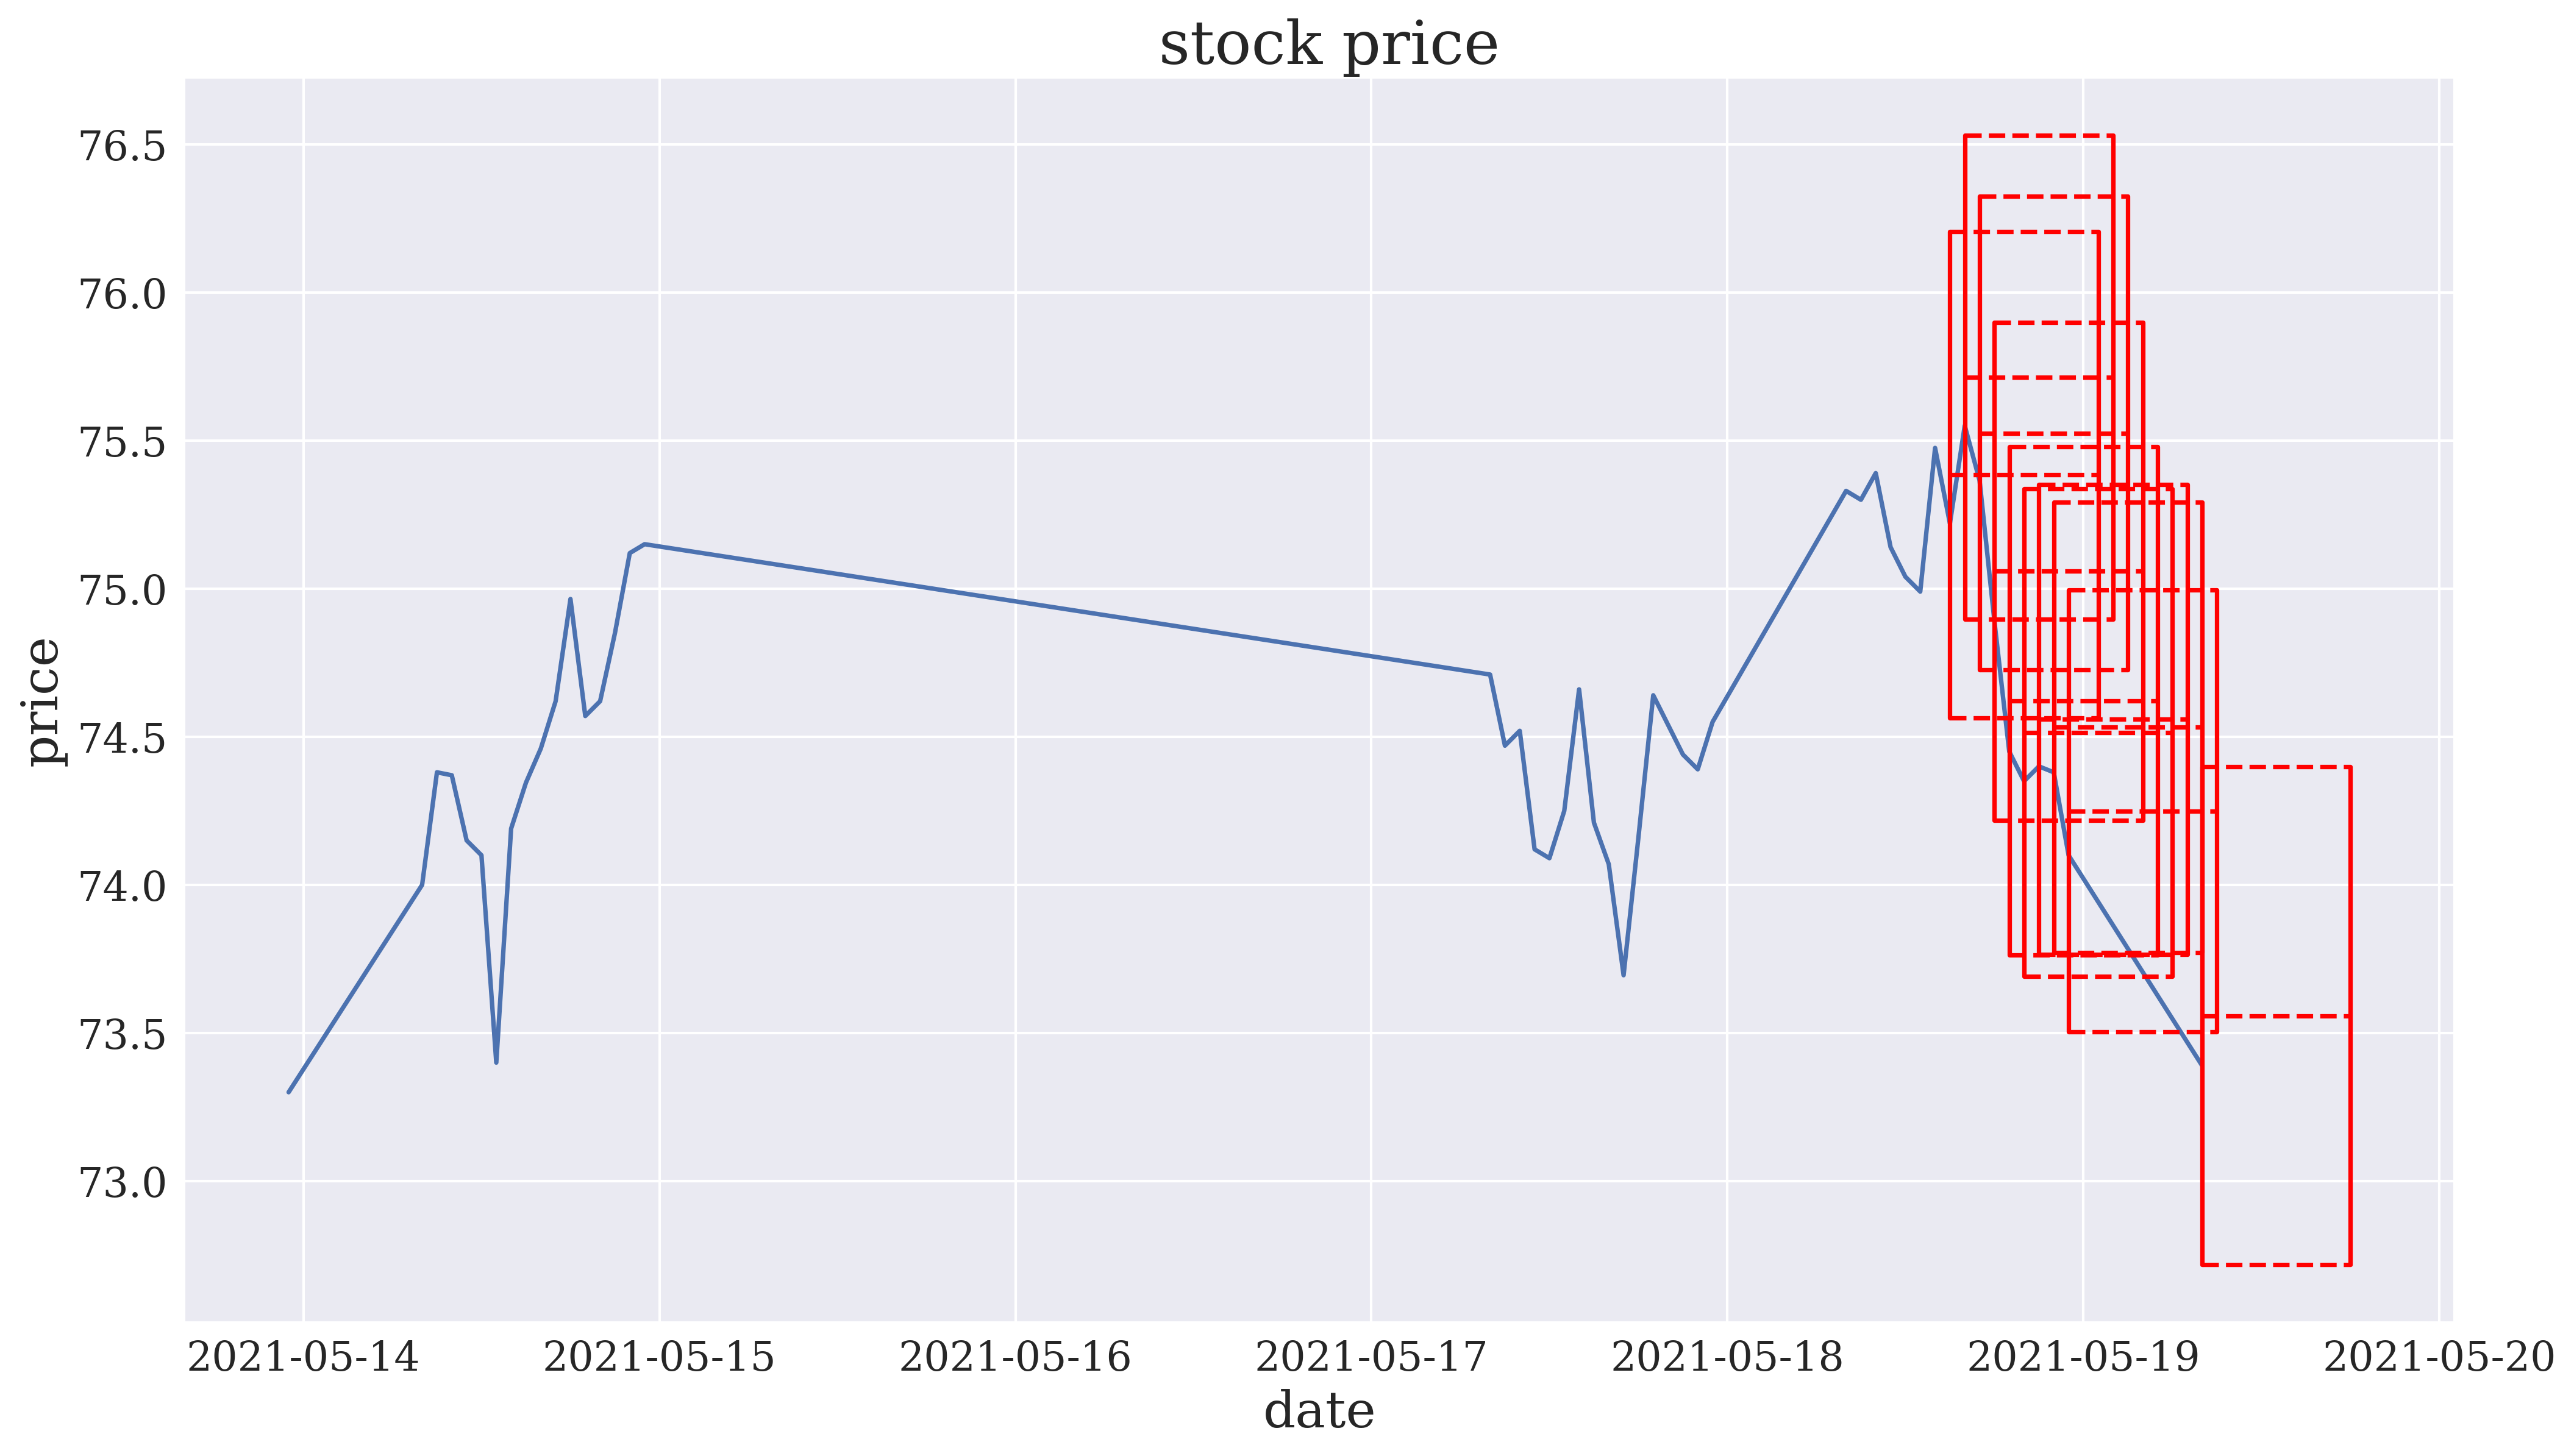

In [20]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-50:])
for i in barriers.index[-10:]:
    barrier = barriers.loc[i]
    start = i
    end = (datetime.strptime(i.strftime("%Y-%m-%d %H:%M:%S"), '%Y-%m-%d %H:%M:%S') + timedelta(hours = 10))
    upper_barrier = barrier.top_barrier
    lower_barrier = barrier.bottom_barrier
    ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
    ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
    ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
    ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
    ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');